<a href="https://colab.research.google.com/github/aftab-ali/Tensorflow2.0/blob/main/LSTM_Malware_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import  joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import SpatialDropout1D
from mlxtend.plotting import plot_confusion_matrix

In [5]:
malware_calls_df = pd.read_csv("calls.zip", compression="zip",
                               sep="\t", names=["API_Calls"])

malware_labels_df = pd.read_csv("types.zip", compression="zip",
                                sep="\t", names=["API_Labels"])

malware_calls_df["API_Labels"] = malware_labels_df.API_Labels
malware_calls_df["API_Calls"] = malware_calls_df.API_Calls.apply(lambda x: " ".join(x.split(",")))

malware_calls_df["API_Labels"] = malware_calls_df.API_Labels.apply(lambda x: 1 if x == "Virus" else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


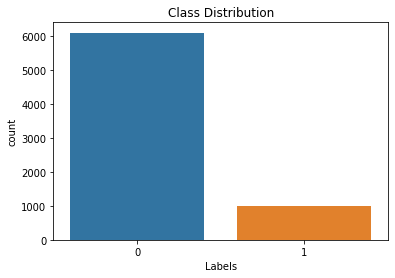

In [6]:
sns.countplot(malware_calls_df.API_Labels)
plt.xlabel('Labels')
plt.title('Class Distribution')
plt.savefig("class_distribution.png")
plt.show()

In [7]:
max_words = 800
max_len = 100

X = malware_calls_df.API_Calls
Y = malware_calls_df.API_Labels.astype('category').cat.codes

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
print('Found %s unique tokens.' % len(tok.word_index))
X = tok.texts_to_sequences(X.values)
X = sequence.pad_sequences(X, maxlen=max_len)
print('Shape of data tensor:', X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

le = LabelEncoder()
Y_train_enc = le.fit_transform(Y_train)
Y_train_enc = np_utils.to_categorical(Y_train_enc)

Y_test_enc = le.transform(Y_test)
Y_test_enc = np_utils.to_categorical(Y_test_enc)

Found 278 unique tokens.
Shape of data tensor: (7107, 100)


In [16]:
# Sequential Model
# activation_function = 'tanh'
def malware_model(act_func="softsign"):
    model = Sequential()
    model.add(Embedding(max_words, 300, input_length=max_len))
    model.add(SpatialDropout1D(0.1))
    model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True, activation=act_func))
    model.add(LSTM(32, dropout=0.1, activation=act_func, return_sequences=True))
    model.add(LSTM(32, dropout=0.1, activation=act_func))
    model.add(Dense(128, activation=act_func))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation=act_func))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation=act_func))
    model.add(Dropout(0.1))
    model.add(Dense(1, name='out_layer', activation="linear"))
    return model

In [17]:
model = malware_model()
print(model.summary())
model.compile(loss='mse', optimizer="rmsprop", metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=1000, epochs=10,
                    validation_data=(X_test, Y_test), verbose=1)
# print(model.predict([X_test, Y_test]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          240000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 32)           42624     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 32)           8320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


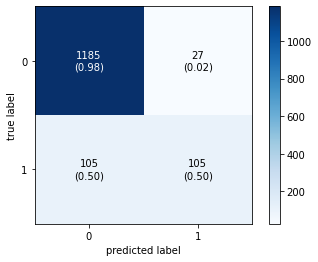

In [18]:
y_test_pred = model.predict_classes(X_test)
cm = confusion_matrix(Y_test, y_test_pred)

plot_confusion_matrix(conf_mat=cm,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True)
plt.savefig("Confusion_Matrix.png")
plt.show()  

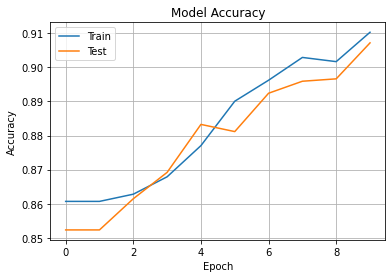

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.savefig("accuracy.png")
plt.show()

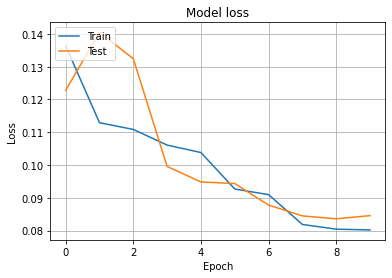

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.savefig("loss.png")
plt.show()